# Network Analytics Project

In [1]:
group_members=['Pankaj Chand', 'Keith Levengood', 'Nicholas Kroeger', 'Varun Puri']
print('Project: CIS6930 Network Analytics & Machine Learning')
print('Group Members:', group_members)

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from datetime import datetime
import pickle

print('\nLibrary Versions')
print('### Python version: ' + __import__('sys').version)
print('### Pandas Version: ' + pd.__version__)
print('### MatPlotLib version:' + matplotlib.__version__)
print('------------')

Project: CIS6930 Network Analytics & Machine Learning
Group Members: ['Pankaj Chand', 'Keith Levengood', 'Nicholas Kroeger', 'Varun Puri']

Library Versions
### Python version: 3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
### Pandas Version: 1.2.2
### MatPlotLib version:3.3.4
------------


# Load in data

In [2]:
import itertools

# Helper function to get the prefix of each APNAME 
def convertAPNameToPrefix(df):
    prefixes = []
    for i in range(len(df)):
        tempPrefix = ["".join(x) for _, x in itertools.groupby(df.iloc[i], key=str.isdigit)][0]
        prefixes.append(tempPrefix)
    return prefixes

In [3]:
loadPreprocessedData = True

In [4]:
if loadPreprocessedData == False:
    #load in csv, append APNAME to end of dataframe, save it out as .pkl
    data = pd.read_csv('DHCP_April_2012_ANON_MAC_devType.csv')
    print("loaded first dataframe")
    
    print("Appending prefix name to table... will take a few minutes")
    
    prefixes_col   = convertAPNameToPrefix(data['APNAME'])
    data['prefix'] = prefixes_col
    
    print("Saving out new dataframe to .pkl file")
    data.to_pickle("./DHCP_April_2012_ANON_MAC_devType_wAPNAME.pkl")
else:
    #load in preprecossed data
    data = pd.read_pickle("./DHCP_April_2012_ANON_MAC_devType_wAPNAME.pkl")

# Look at the data

In [5]:
data.head(), data.shape

(           userIP  userMAC                APNAME              APMAC  \
 0   10.131.172.58    26257  fli113-win-lap3502-1  44:e4:d9:00:ed:e0   
 1        10.0.1.3    22699  hrb112-win-lap1231-1  00:1a:a2:09:93:90   
 2  10.132.190.205    30264  soc1402-temp-lap3502  58:35:d9:d5:cd:c0   
 3  10.130.146.252    72815  soc1402-temp-lap3502  58:35:d9:d5:cd:c0   
 4   10.130.248.68    69249               unknown  00:00:00:00:00:00   
 
     startTime     endTime deviceType   prefix  
 0  1333238682  1333238682          f      fli  
 1  1333238682  1333238687    unknown      hrb  
 2  1333238685  1333238687          f      soc  
 3  1333238688  1333238688          f      soc  
 4  1333238690  1333238690          f  unknown  ,
 (22821939, 8))

2012-04-01 00:04:41
2012-05-01 00:05:20


<AxesSubplot:>

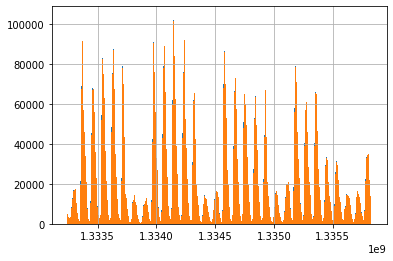

In [6]:
print(pd.to_datetime(data['startTime'].min(), unit='s'))
print(pd.to_datetime(data['endTime'].max(), unit='s'))
data['startTime'].hist(bins=1000)
data['endTime'].hist(bins=1000)

# Load in prefix and building information

In [7]:
prefix_lat_lon = pd.read_csv('prefix_lat_lon_name_category.csv')
legalPrefixes = prefix_lat_lon.prefix


In [8]:
print(prefix_lat_lon)

    prefix        lat        lon                             name  category
0      aaf  29.650275 -82.345720         Academic Advising Center     admin
1      adv  29.648792 -82.359303  Martin H. Levin Advocacy Center  academic
2      aer  29.643272 -82.348300       Mec. Aerospace Engineering  academic
3     aerv  29.643272 -82.348300       Mec. Aerospace Engineering  academic
4      alf  29.642948 -82.348636   Alfred A. Ring Tennis Pavilion    sports
..     ...        ...        ...                              ...       ...
189   weim  29.647761 -82.347342                      Wiemer Hall  academic
190  weimG  29.647761 -82.347342                      Wiemer Hall  academic
191  weimg  29.647761 -82.347342                      Wiemer Hall  academic
192     wm  29.648052 -82.346709                  Williamson Hall  academic
193    yon  29.649968 -82.347888                         Yon Hall  academic

[194 rows x 5 columns]


In [9]:
legalPrefixes.head()

0     aaf
1     adv
2     aer
3    aerv
4     alf
Name: prefix, dtype: object

# Clean the data

In [10]:
#prefixes found from our preprocessing function
#prefixesFound = np.unique(data.prefix)
prefixesFound = data['prefix'].unique()

In [11]:
#prefixes in the base table that don't match in the prefix table 
#TODO: more preprocessing to keep some of these?
unknownPrefixes = list(np.setdiff1d(prefixesFound, np.asarray(legalPrefixes)))

In [12]:
unknownPrefixes

['AP',
 'APc',
 'APe',
 'APf',
 'apopka',
 'apopka-win-lap',
 'b',
 'cba-ftlauderdale-win-lap',
 'ctx',
 'dairy-win-lap',
 'ecob',
 'escv',
 'flrec',
 'hotidf-win-lap',
 'irrec',
 'mowv',
 'ohl',
 'osbs-win-lap',
 'osbs-xxx-win-lap',
 'osbstr',
 'pep',
 'presAttic-wout-lap',
 'presStairs-win-lap',
 'rl',
 'rubygillhs-win-lap',
 'treeo-win-lap',
 'uic-win-lap',
 'unknown',
 'wrt']

In [13]:
#keep only valid prefixes (based on the prefix_lat_lon_name_category.csv table)
#removes about 400k rows?
data = data[~data['prefix'].isin(unknownPrefixes)]
data.shape

(18867555, 8)

In [14]:
# Keep only sessions longer than 10 seconds. Removes ~ 7 million receords. 
data = data[data['endTime']-data['startTime'] > 30]
print(data.shape)
data.head()

(9179058, 8)


,userIP,userMAC,APNAME,APMAC,startTime,endTime,deviceType,prefix
32,10.131.163.198,12544,gri101-wout-lap1231-1,00:1a:e2:10:ba:90,1333238683,1333238723,f,gri
41,10.132.190.177,33782,soc-temp-lap3502-5,88:f0:77:f2:67:a0,1333238693,1333238733,f,soc-temp-lap
42,10.132.251.191,85756,soc-temp-lap3502-2,88:f0:77:f2:5f:a0,1333238692,1333238736,f,soc-temp-lap
45,10.132.190.116,59170,soc-temp-lap3502-4,88:f0:77:f2:60:e0,1333238694,1333238738,f,soc-temp-lap
46,10.132.255.218,23629,soc-temp-lap3502-1,88:f0:77:f2:6b:80,1333238691,1333238741,unknown,soc-temp-lap


In [15]:
# Remove all records with users who have had fewer than 500 sessions 
data = data.groupby('userMAC').filter(lambda x : len(x)>500)
print(data.shape)

(3722227, 8)


## Get information about each user (useful for prediction later)

In [16]:
numUsers = data['userMAC'].unique().shape[0]

In [17]:
location_info = prefix_lat_lon[['prefix','name','category']]
location_info.head()

,prefix,name,category
0,aaf,Academic Advising Center,admin
1,adv,Martin H. Levin Advocacy Center,academic
2,aer,Mec. Aerospace Engineering,academic
3,aerv,Mec. Aerospace Engineering,academic
4,alf,Alfred A. Ring Tennis Pavilion,sports


## Association Matrix

In [18]:
data_start = data['startTime'].min()
data_end = data['endTime'].max()
step = 3600
time_slots = np.arange(data_start, data_end, step)
#time_slots[-1] = data_end
print(time_slots.shape)

(721,)


In [19]:
print(data_start, data_end)
print(time_slots)

1333238682 1335830719
[1333238682 1333242282 1333245882 1333249482 1333253082 1333256682
 1333260282 1333263882 1333267482 1333271082 1333274682 1333278282
 1333281882 1333285482 1333289082 1333292682 1333296282 1333299882
 1333303482 1333307082 1333310682 1333314282 1333317882 1333321482
 1333325082 1333328682 1333332282 1333335882 1333339482 1333343082
 1333346682 1333350282 1333353882 1333357482 1333361082 1333364682
 1333368282 1333371882 1333375482 1333379082 1333382682 1333386282
 1333389882 1333393482 1333397082 1333400682 1333404282 1333407882
 1333411482 1333415082 1333418682 1333422282 1333425882 1333429482
 1333433082 1333436682 1333440282 1333443882 1333447482 1333451082
 1333454682 1333458282 1333461882 1333465482 1333469082 1333472682
 1333476282 1333479882 1333483482 1333487082 1333490682 1333494282
 1333497882 1333501482 1333505082 1333508682 1333512282 1333515882
 1333519482 1333523082 1333526682 1333530282 1333533882 1333537482
 1333541082 1333544682 1333548282 133355

In [20]:
numLocations = location_info['name'].unique().shape[0]
print(numLocations)

137


In [21]:
def encounter_length(sa, ea, sb, eb):
    smax = sa if sa > sb else sb
    emin = ea if ea < eb else eb
    return emin - smax

In [22]:
from ncls import NCLS

In [23]:
#create dict mapping prefix to building name
name_prefix_codes = dict(zip(location_info.prefix, location_info.name))

In [24]:
def generateAssociationMatrices():
    ass_mats = [0]*numUsers
    usermacs = [0]*numUsers
    inds = np.arange(0, len(time_slots))
    #print("indx", inds)
    #print(time_slots)
    int_tree = NCLS(time_slots.astype(np.int64), (time_slots + step).astype(np.int64), inds.astype(np.int64))

    counter = 0
    for user in data['userMAC'].unique():
        if (counter % 5 == 0):
            print("User ", counter, '/', numUsers)
        #ass_mat = np.zeroes((time_slots.shape[0], numLocations))
        ass_mat = pd.DataFrame(0, index=time_slots, columns=location_info['name'].unique())
        userSessions = data[data['userMAC'] == user]
        
        for session in userSessions.iterrows():
            start = session[1]['startTime']
            end =  session[1]['endTime']
            overlaps = int_tree.find_overlap(start, end)
            for o in overlaps:
                enc_len = encounter_length(start, end, o[0], o[1])
                prefix = session[1]['prefix']
                #sessionBuildingName = location_info[location_info['prefix'] == prefix] ['name']
                sessionBuildingName = name_prefix_codes[prefix]
                ass_mat.loc[o[0]][sessionBuildingName] += enc_len
        
        ass_mats[counter] = ass_mat
        usermacs[counter] = user
        counter+=1

    return ass_mats


In [25]:
def generateBuildingVectors():
    bldg_vecs = [0]*numUsers
    usermacs  = [0]*numUsers
    inds = np.arange(0, len(time_slots))
    #print("indx", inds)
    #print(time_slots)
    int_tree = NCLS(time_slots.astype(np.int64), (time_slots + step).astype(np.int64), inds.astype(np.int64))
    np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
    counter = 0
    for user in data['userMAC'].unique():
        if (counter % 5 == 0):
            print("User ", counter, '/', numUsers)
        if counter > 2500:
            break
        #ass_mat = np.zeroes((time_slots.shape[0], numLocations))
        ass_mat = pd.DataFrame(0, index=time_slots, columns=location_info['name'].unique())
        userSessions = data[data['userMAC'] == user]
        
        for session in userSessions.iterrows():
            start = session[1]['startTime']
            end =  session[1]['endTime']
            overlaps = int_tree.find_overlap(start, end)
            for o in overlaps:
                enc_len = encounter_length(start, end, o[0], o[1])
                prefix = session[1]['prefix']
                #sessionBuildingName = location_info[location_info['prefix'] == prefix] ['name']
                sessionBuildingName = name_prefix_codes[prefix]
                ass_mat.loc[o[0]][sessionBuildingName] += enc_len
        ass_mat = np.asarray(ass_mat)
        
        tempBldgVec = np.zeros((len(time_slots), 1))   
        for i in range(len(time_slots)): #loop all the time slots
            if np.sum(ass_mat[i]) == 0: #havent been in any buildings for this time slot
                if counter == 0: #first iter
                    tempBldgVec[i] = np.random.randint(numLocations) #randomly pick a location 
                else: #still not in a building
                    tempBldgVec[i] = bldg_vecs[counter-1][i] #take prev building
            else:
                tempBldgVec[i] = np.argmax(ass_mat[i]) #get building index
        bldg_vecs[counter] = tempBldgVec
        usermacs[counter]  = user
        counter+=1

    return bldg_vecs, usermacs


In [28]:
#mats = generateAssociationMatrices()
#Save association matrices (takes a long time to make them)
#mats.to_pickle("./AssociationMatrices.pkl")

if loadPreprocessedData == False:
    bldgHistoryPerPerson, usermacs = generateBuildingVectors()
    with open('BldgHistoryPerPerson.npy', 'wb') as f:
        np.save(f, bldgHistoryPerPerson)
    with open('userMacInfo_BldgHistory.npy', 'wb') as f:
        np.save(f, usermacs)
else:
    bldgHistoryPerPerson = np.load('BldgHistoryPerPerson.npy', allow_pickle=True)
    usermacs = np.load('userMacInfo_BldgHistory.npy', allow_pickle=True)


#DESCRIPTION: Each entry in the list is a user. Each user has an array over time of 
#             their most used building in that time slot

In [41]:
# # Normalize per row
# def normalizeAssMat(mats):
#     for i in range(0, len(mats)):
#         mats[i] = mats[i].div(mats[i].sum(axis=1), axis=0)
#         mats[i].fillna(value=0, inplace=True)
#     return mats

In [42]:
# normalizedMats = normalizeAssMat(mats[:5])
# print(normalizedMats[1].head())

In [34]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
def ClusterWithAssMats():
    #Clustering with ass_mats

    numTimeSlots = len(time_slots)
    numLocs = mats[0].shape[1]
    X = [0]*100 #np.zeros((numUsers*numTimeSlots, numLocs))
    for i in range(100):
        X[i] = mats[i]
    X = np.asarray(X)
    print(X.shape)
    X = X.reshape(100*numTimeSlots, numLocs)
    print(X.shape)
    
    kmeans = KMeans(n_clusters = 5, random_state = 0).fit(X)
    clusterCenters = kmeans.cluster_centers_
    labels = kmeans.labels_ 
    print("labels", labels)
    
    MC_Cluster = labels.reshape(100, 2881).T
    unique, counts = np.unique(labels, return_counts=True)
    print(unique, counts)
    
    #Try PCA on data and cluster it
    pca = PCA(n_components = 3)
    X_pca = pca.fit_transform(X)
    print(pca.explained_variance_ratio_.cumsum())
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2])
    plt.show()

    kmeans_pca = KMeans(n_clusters = 5, random_state=5).fit(X_pca)

In [35]:
#Cluster the building time-series vector for each person
#Temporarily use part of this array
X = np.stack(bldgHistoryPerPerson[:2500],axis=1).squeeze().T
X.shape

(2500, 721)

In [37]:
#Custom distance metric (based on building location)
if loadPreprocessedData == False:
    BldgsCoords = [0]*numLocations
    unique_bldgs = prefix_lat_lon['name'].unique()

    for i in range(numLocations):
        BldgsCoords[i] = prefix_lat_lon[prefix_lat_lon.name == unique_bldgs[i]][['lat','lon']].iloc[0]

    with open('BldgsCoords.npy', 'wb') as f:
        np.save(f, BldgsCoords)
    with open('BldgDict.npy', 'wb') as f:
        np.save(f, bldg_dict)
else:
    BldgsCoords = np.load('BldgsCoords.npy', allow_pickle=True)
    bldg_dict = np.load('BldgDict.npy', allow_pickle=True)

In [38]:
BldgsCoords

array([[ 29.650275, -82.34572 ],
       [ 29.648792, -82.359303],
       [ 29.643272, -82.3483  ],
       [ 29.642948, -82.348636],
       [ 29.651573, -82.341939],
       [ 29.631292, -82.351768],
       [ 29.631292, -82.351768],
       [ 29.646905, -82.343942],
       [ 29.647656, -82.341748],
       [ 29.648887, -82.342909],
       [ 29.643915, -82.344403],
       [ 29.639509, -82.359952],
       [ 29.639518, -82.359949],
       [ 29.647961, -82.351393],
       [ 29.649216, -82.359055],
       [ 29.641892, -82.347876],
       [ 29.646552, -82.342104],
       [ 29.648906, -82.345784],
       [ 29.648906, -82.345784],
       [ 29.645354, -82.347903],
       [ 29.645256, -82.34771 ],
       [ 29.645442, -82.348053],
       [ 29.64903 , -82.341675],
       [ 29.64903 , -82.341675],
       [ 29.652971, -82.342913],
       [ 29.643928, -82.343066],
       [ 29.64272 , -82.347873],
       [ 29.650947, -82.344073],
       [ 29.64635 , -82.346664],
       [ 29.639071, -82.368803],
       [ 2

In [42]:
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.elbow import elbow
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES

from pyclustering.cluster.kmedians import kmedians

from haversine import haversine, Unit
import math
import pyclustering.utils.metric
from pyclustering.utils.metric import distance_metric, type_metric

In [40]:
def building_dist_metric(a, b):
    coords_a = [BldgsCoords[int(x)] for x in a]
    coords_b = [BldgsCoords[int(x)] for x in a]
    
    totalDist = 0
    
    for i in range(0,len(coords_a)):
        totalDist += haversine(coords_a[i], coords_b[i])
        
    return math.sqrt(totalDist)
bldg_dist_func = lambda point1, point2: building_dist_metric(point1, point2)
bldg_dist_metric = distance_metric(type_metric.USER_DEFINED, func=bldg_dist_func)

In [43]:
# Initialize initial medoids using K-Means++ algorithm
initial_medoids = kmeans_plusplus_initializer(X, 4).initialize(return_index=True)
 
# Create instance of K-Medoids (PAM) algorithm.
kmedians_instance = kmedians(X, initial_medoids, metric = bldg_dist_metric)

# Run cluster analysis and obtain results.
kmedians_instance.process()
clusters = kmedians_instance.get_clusters()
medoids = kmedians_instance.get_medoids()
 
# Print allocated clusters.
print("medoids:", medoids)

TypeError: object of type 'numpy.int64' has no len()

In [71]:
# create instance of Elbow method using K value from 1 to 10.
kmin, kmax = 1, 75
elbow_instance = elbow(X, kmin, kmax)
 
# process input data and obtain results of analysis
elbow_instance.process()
amount_clusters = elbow_instance.get_amount()  # most probable amount of clusters
wce = elbow_instance.get_wce()  # total within-cluster errors for each K
print("finished elbow")
manhattan_metric = distance_metric(type_metric.MANHATTAN)

# perform cluster analysis using K-Means algorithm

centers = kmeans_plusplus_initializer(X, amount_clusters,
                      amount_candidates=kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE,
                      metric = bldg_dist_metric).initialize()
kmeans_instance = kmeans(X, centers)
kmeans_instance.process()

# obtain clustering results and visualize them
clusters = kmeans_instance.get_clusters()
means    = kmeans_instance.get_centers()

finished elbow


In [172]:
with open('kmeans_instance.npy', 'wb') as f:
    np.save(f, kmeans_instance)
with open('clusters.npy', 'wb') as f:
    np.save(f, clusters)
with open('means.npy', 'wb') as f:
    np.save(f, means)

/Users/nkroeger/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [72]:
roundedMeans = [np.rint(x) for x in means]

19


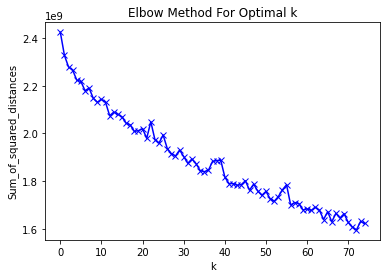

In [73]:
print(amount_clusters)
plt.plot(np.arange(len(wce)), wce, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
#KMedoids Sklearn (custom distance metric)
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=2, random_state=0).fit(X)

# Markov Chain

In [74]:
def MakeTransitionMatrix(history, NumComponents, normalize=True):
#      Input: DataArray - array of length N of integers that belong to 1 of C classes
#      Output: TransMat - is a right stochastic matrix (each row sums to 1)
#                         Each entry of TransMat(i,j) represents the probability
#                         of going from label i to label j
    NumTimeSteps  = len(history)
    
    #Pre-allocate transition matrix
    TransMat = np.ones((NumComponents+1, NumComponents+1)) #+1 because 0-indexed

    for i in range(NumTimeSteps-1):
        Current = history[i]
        Next    = history[i+1]
        TransMat[Current, Next] = TransMat[Current, Next] + 1
        
    #Normalize rows
    if normalize:
        TransMat = TransMat/np.sum(TransMat,1)[:,None] #broadcast vector for normalization by rows
    return TransMat

In [75]:
def FindNextState(TransMat, state, loc_dict, plotNextStateProb=False):
    #assume state is 0-indexed
    rand = np.random.random()
    
    #Make cdf of transitioning out of a given state
    cdf = np.cumsum(TransMat[state])    

    #find first state above random number on cdf
    nextState = np.where(cdf > rand)[0][0]
    if plotNextStateProb: #plot cdf and probability of transitioning
        StateSize = len(TransMat)
        plt.figure(dpi=100)
        plt.plot(np.insert(cdf, 0, 0))
        plt.title("Cumulative Distribution function" + " - Chose state " + str(nextState) + ' ' + loc_dict[nextState])
        plt.axhline(rand, c='red')
        for i in range(StateSize):
            plt.axvline(i, c='k')
        plt.show()
    
    return nextState

In [76]:
def PredictFutureSteps(TransMat, MostRecentState, bldg_dict, NumFutureSteps, PlotCDF=False):
    nextStates  = []
    nextBldgs   = []
    currState   = MostRecentState
    for i in range(NumFutureSteps):
        nextState = FindNextState(TransMat, currState, bldg_dict, PlotCDF)
        #print("\nNext state", bldg_dict[nextState])
        nextStates.append(nextState)
        nextBldgs.append(bldg_dict[nextState])
        currState = nextState

    #print("Next states array:", nextStates)
    #print("Next buildings array:", nextBldgs)
    return nextStates, nextBldgs

## Toy example for Markov Chain

In [77]:
# demo of a Markov chain predictor

#Toy data
bldg_dict = {0: 'Not Connected', 
             1: 'hub',
             2: 'reitz',
             3: 'lib west'}

personHistory = np.array([0,0,0,1,1,2,2,1,2,3,2,3,2,3,1,2,0,1,0])

#Make transition matrix
TransMat = MakeTransitionMatrix(personHistory,3)
print("TransMat:\n", TransMat)

#Predict future steps based on their most recent history
NumFutureSteps  = 5
MostRecentState = personHistory[-1]
nextSteps, nextBldgs = PredictFutureSteps(TransMat, MostRecentState, bldg_dict, NumFutureSteps, PlotCDF=False)
nextSteps, nextBldgs

TransMat:
 [[0.375      0.375      0.125      0.125     ]
 [0.22222222 0.22222222 0.44444444 0.11111111]
 [0.2        0.2        0.2        0.4       ]
 [0.14285714 0.28571429 0.42857143 0.14285714]]


([0, 0, 3, 0, 1],
 ['Not Connected', 'Not Connected', 'lib west', 'Not Connected', 'hub'])

# MC prediction on each cluster
Make Transition Matrix on entire cluster, leave 1 person out. 
Use remaining users in cluster to build transition matrix.
User left-out user to predict 1 step ahead, compare to ground truth. 

In [80]:
bldgs     = location_info['name'].unique()
bldg_dict = dict(zip(np.arange(len(bldgs)), bldgs))

In [81]:
bldg_dict

{0: 'Academic Advising Center',
 1: 'Martin H. Levin Advocacy Center',
 2: 'Mec. Aerospace Engineering',
 3: 'Alfred A. Ring Tennis Pavilion',
 4: 'Anderson Hall',
 5: 'Animal Science',
 6: 'Animal Science Building C',
 7: 'Aquatic Products Lab',
 8: 'School of Architecture',
 9: 'University Auditorium',
 10: 'Bartram Hall',
 11: 'BioContainment Facility',
 12: 'Bio-Containment Facility',
 13: 'Tolbert Hall',
 14: 'Bruton-Geer Hall',
 15: 'Black Hall',
 16: 'Broward Hall',
 17: 'Bryant Space Science Center',
 18: 'Bryan Hall',
 19: 'UF bookstore',
 20: 'UF Bookstore',
 21: 'UF Welcome Center',
 22: 'Carleton Auditorium',
 23: 'Carleton Auditorium - Attic',
 24: 'Classroom Building 105',
 25: 'Centrex Building',
 26: 'Dept. of Chemical Engineering',
 27: 'Chemistry Lab',
 28: 'Constans Theatre',
 29: 'Center for Outdoor Rec. & Educ.',
 30: 'Criser Hall',
 31: 'Carr Hall',
 32: 'CISE',
 33: 'Crops And Soils Field Lab',
 34: 'Lacy R. Chilled Water Plt. CWP2',
 35: 'Dauer Hall',
 36: 'Fres

In [147]:
NumClusters = len(roundedMeans)
nBuildings = 137

In [153]:
#Get the average accuracy for each cluster
AvgAccPerCluster = []
for clusterIdx in range(NumClusters):
    print("Cluster:", clusterIdx)
    #find all people within a cluster
    AccPerPerson = []
    UsersInCluster    = clusters[clusterIdx]
    NumUsersInCluster = len(UsersInCluster)
    for u in range(NumUsersInCluster):
        TempUsersInCluster = UsersInCluster.copy()
        UserToPredict      = TempUsersInCluster[u]
        TempUsersInCluster.remove(UserToPredict) #remove person to use prediction
        ClusterSubsetForTransMat = TempUsersInCluster

        #Grab the data associated with a person's cluster assignment
        ClusterHistory = X[ClusterSubsetForTransMat].astype(int)
        NumUsersInSubCluster = len(ClusterSubsetForTransMat)
        TransMat = np.zeros((nBuildings, nBuildings))
        for i in range(NumUsersInSubCluster):
            userHistory = ClusterHistory[i]
            TransMat += MakeTransitionMatrix(userHistory, nBuildings-1, False)
        TransMat = TransMat/np.sum(TransMat,1)[:,None] #normalize

        #Predict each successive step for the left-out user
        NumFutureSteps = 1
        NumCorrect = 0
        userHistory = X[UserToPredict].astype(int)
        for t in range(len(userHistory)-1):  
            MostRecentState = userHistory[i]
            nextSteps, nextBldgs = PredictFutureSteps(TransMat, MostRecentState, bldg_dict, NumFutureSteps, PlotCDF=False)

            if nextSteps[0] == userHistory[t+1]: #Does it match the ground truth?
                NumCorrect += 1
        UserAccuracy = NumCorrect/(len(userHistory)-1)*100
        AccPerPerson.append(UserAccuracy)
    AvgAcc = round(np.array(AccPerPerson).mean(),2)
    print("Average MC(O=1) prediction accuracy for cluster: " + str(clusterIdx) + " is " + str(AvgAcc))
    AvgAccPerCluster.append(AvgAcc)

Cluster: 0
Average MC(O=1) prediction accuracy for cluster: 0 is 1.42
Cluster: 1
Average MC(O=1) prediction accuracy for cluster: 1 is 2.69
Cluster: 2
Average MC(O=1) prediction accuracy for cluster: 2 is 3.28
Cluster: 3
Average MC(O=1) prediction accuracy for cluster: 3 is 1.1
Cluster: 4
Average MC(O=1) prediction accuracy for cluster: 4 is 1.06
Cluster: 5
Average MC(O=1) prediction accuracy for cluster: 5 is 3.41
Cluster: 6
Average MC(O=1) prediction accuracy for cluster: 6 is 1.16
Cluster: 7
Average MC(O=1) prediction accuracy for cluster: 7 is 0.72
Cluster: 8
Average MC(O=1) prediction accuracy for cluster: 8 is 0.75
Cluster: 9
Average MC(O=1) prediction accuracy for cluster: 9 is 1.89
Cluster: 10
Average MC(O=1) prediction accuracy for cluster: 10 is 1.49
Cluster: 11
Average MC(O=1) prediction accuracy for cluster: 11 is 2.71
Cluster: 12
Average MC(O=1) prediction accuracy for cluster: 12 is 1.33
Cluster: 13
Average MC(O=1) prediction accuracy for cluster: 13 is 1.97
Cluster: 14
A

In [154]:
BaselineAcc = round(1/137 *100, 3)
print('Baseline:', BaselineAcc)

Baseline: 0.73


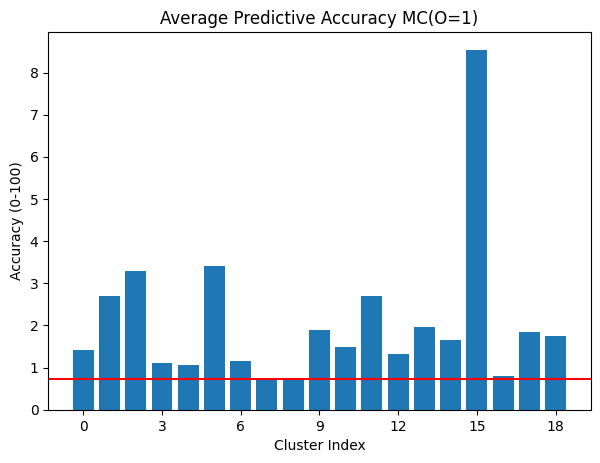

In [165]:
from matplotlib.ticker import MaxNLocator
ax = plt.figure(figsize=(7,5), dpi=100).gca()
ax.bar(np.arange(NumClusters), np.array(AvgAccPerCluster))
ax.axhline(y=BaselineAcc, color='r', linestyle='-')
ax.set_title('Average Predictive Accuracy MC(O=1)')
ax.set_xlabel('Cluster Index')
ax.set_ylabel('Accuracy (0-100)')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))


In [169]:
clusterLens = [len(c) for c in clusters]

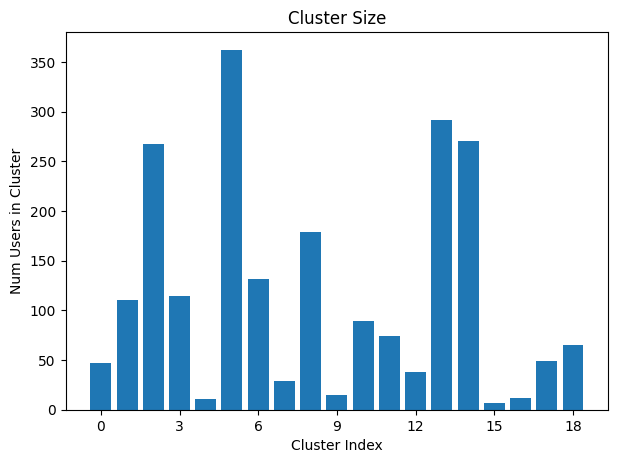

In [170]:
from matplotlib.ticker import MaxNLocator
ax = plt.figure(figsize=(7,5), dpi=100).gca()
ax.bar(np.arange(NumClusters), np.array(clusterLens))
ax.set_title('Cluster Size')
ax.set_xlabel('Cluster Index')
ax.set_ylabel('Num Users in Cluster')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))


In [241]:
#QUICK CODE FOR DEMO
cluster1History = roundedMeans[clusterIdx].astype(int)
TransMat = MakeTransitionMatrix(cluster1History, nBuildings-1)
print(TransMat)

[[0.00729927 0.00729927 0.00729927 ... 0.00729927 0.00729927 0.00729927]
 [0.00729927 0.00729927 0.00729927 ... 0.00729927 0.00729927 0.00729927]
 [0.00729927 0.00729927 0.00729927 ... 0.00729927 0.00729927 0.00729927]
 ...
 [0.00729927 0.00729927 0.00729927 ... 0.00729927 0.00729927 0.00729927]
 [0.00729927 0.00729927 0.00729927 ... 0.00729927 0.00729927 0.00729927]
 [0.00729927 0.00729927 0.00729927 ... 0.00729927 0.00729927 0.00729927]]


In [260]:
#Predict future steps based on their most recent history
NumFutureSteps  = 10
MostRecentState = cluster1History[-1]
bldgs = location_info['name'].unique()
bldg_dict = dict(zip(np.arange(len(bldgs)), bldgs))
nextSteps, nextBldgs = PredictFutureSteps(TransMat, MostRecentState, bldg_dict, NumFutureSteps, PlotCDF=False)
nextSteps, nextBldgs

([99, 61, 112, 18, 58, 8, 83, 89, 124, 16],
 ['Phelps Lab',
  'The Hub',
  'Research Laboratory 2',
  'Bryan Hall',
  'Hough Hall Business School',
  'School of Architecture',
  'Mehrhof Hall',
  'Physics',
  'SW Recreation Center',
  'Broward Hall'])

In [261]:
with open('cluster1History.npy', 'wb') as f:
    np.save(f, cluster1History)
with open('nextSteps.npy', 'wb') as f:
    np.save(f, nextSteps)
    
cluster1History
nextSteps

[99, 61, 112, 18, 58, 8, 83, 89, 124, 16]